In [1]:
import pandas as pd
import datetime
import numpy as np
import pingouin as pg
from scipy import stats
from scipy.stats import ttest_ind
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

**Задание 1**

Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока).

In [2]:
#Скачаем датафрэймы
df_reg  = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-n-eshmanskaja/shared/problem1-reg_data.csv', sep = ';')
df_auth = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-n-eshmanskaja/shared/problem1-auth_data.csv', sep = ';')

In [3]:
df_reg.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [4]:
df_reg.shape

(1000000, 2)

In [5]:
df_reg.dtypes

reg_ts    int64
uid       int64
dtype: object

In [6]:
#Так как количество уникальных id совпадает с размером таблицы, дублей id в ней нет
df_reg.uid.nunique()

1000000

In [7]:
df_auth.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [8]:
df_auth.shape

(9601013, 2)

In [9]:
df_auth.dtypes

auth_ts    int64
uid        int64
dtype: object

In [10]:
#Количество уникальных id в обеих таблицах совпадает
df_auth.uid.nunique()

1000000

In [11]:
#Посмотрим первую дату регистрации пользователя
pd.to_datetime(df_reg['reg_ts'], unit='s').min()

Timestamp('1998-11-18 09:43:43')

In [12]:
#Посмотрим последнюю имеющуюся дату
pd.to_datetime(df_auth['auth_ts'], unit='s').max()

Timestamp('2020-09-23 15:17:24')

In [13]:
def retention(tab_registration, tab_authentication,first_date, last_date):
    
    '''
    tab_registration - таблица с уникальными id игрока и датой его регистрации
    tab_authentication - таблица со временем захода пользователя в игру
    first_date - дата, с которой считаем retention
    last_date - дата, по которую считаем retention
    '''
    
    #Объединяем данные в 1 таблицу:
    df_final = pd.merge(tab_registration, tab_authentication, on='uid')
    
    # Преобразуем числа в даты:
    df_final['cohort_date'] = pd.to_datetime(df_final['reg_ts'], unit='s').dt.date
    df_final['auth_date'] = pd.to_datetime(df_final['auth_ts'], unit='s').dt.date
    
    #Выбираем период, за который будем рассчитывать когорты
    df_final = df_final.query("cohort_date >= @first_date and auth_date <= @last_date" )
    
    #Считаем разницу в днях между регистрацией и аутентификацией:
    df_final['days'] = (df_final['auth_date'] - df_final['cohort_date']).dt.days + 1
    
    #Группируем когорты
    df_final = df_final\
        .groupby(['cohort_date', 'days'], as_index = False)\
        .nunique ('uid')   
    
    #Преобразуем в сводную таблицу
    df_final_pivot = df_final.pivot(index='cohort_date', columns='days', values='uid')
    
    #Рассчитаем retention
    retention = df_final_pivot.divide(df_final_pivot[1], axis=0).round(4)
    
    #Визуализируем когорты
    plt.rcParams['font.size'] = '11'
    sns.set(style='ticks')
    plt.figure(figsize=(24, 16))
    plt.title('Cohorts: User Retention')
    sns.heatmap(data=retention, annot=True, vmin=0.0,vmax=0.1, fmt='.2%',cmap='Blues' )
    plt.show()

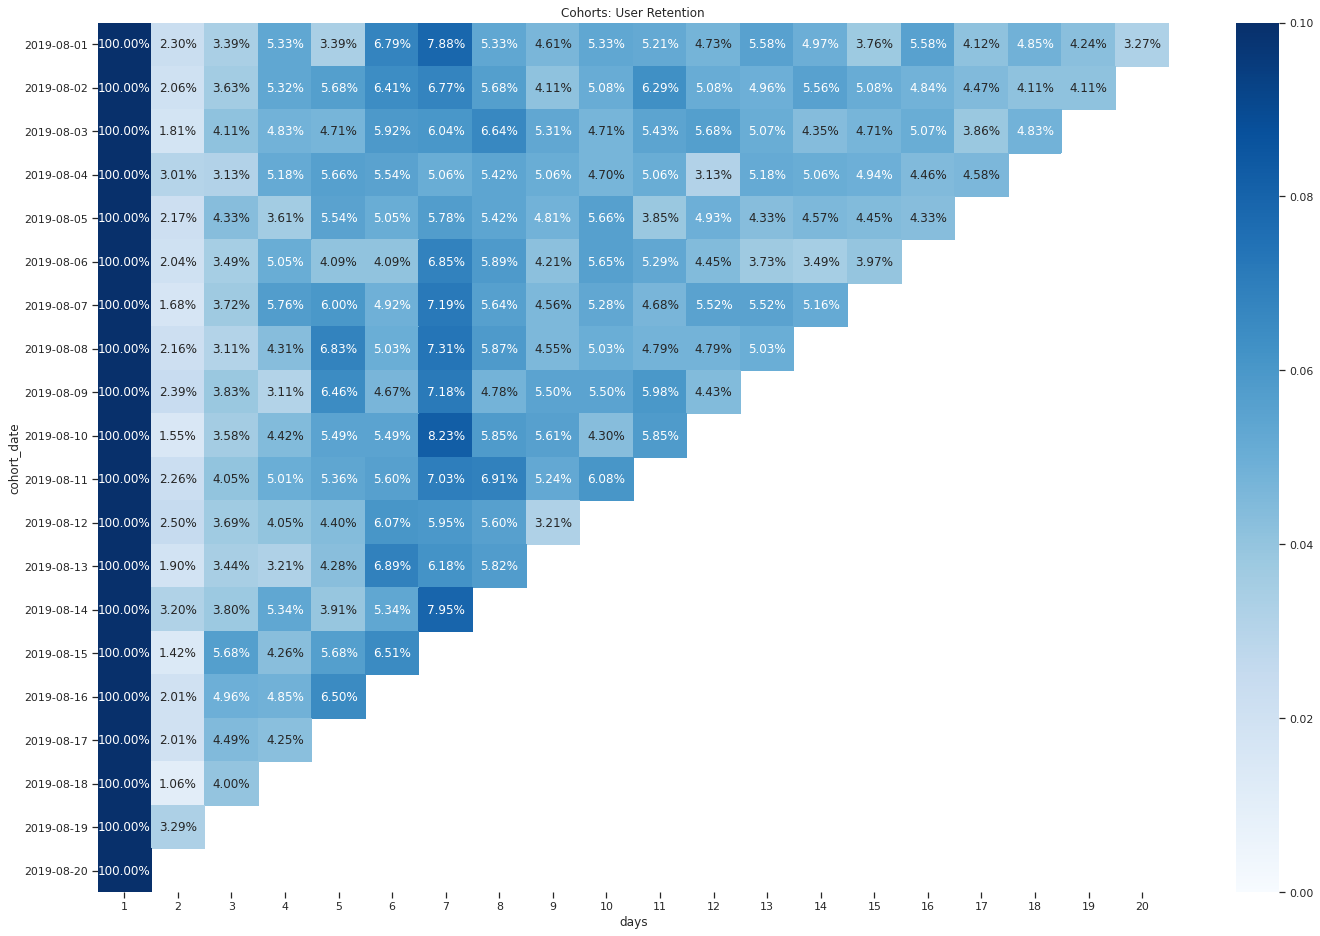

In [14]:
#Проверим работу функции на данных с 1 по 20 августа 2019 г
retention(tab_registration = df_reg, 
          tab_authentication = df_auth,
          first_date = datetime.date (2019, 8, 1),
          last_date = datetime.date (2019, 8, 20))

**Задание 2**

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [15]:
#Загрузим датафрэйм
df = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/SOkIsD5A8xlI7Q', sep=';')

In [16]:
df.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [17]:
df.shape

(404770, 3)

In [18]:
df.dtypes

user_id       int64
revenue       int64
testgroup    object
dtype: object

In [19]:
#Проверим на наличие пропущенных значений
df.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

In [20]:
#Посмотрим на размер групп, они практически равны
df\
    .groupby('testgroup', as_index = False)\
    .agg({'user_id' : 'count'})

,testgroup,user_id
0,a,202103
1,b,202667


In [21]:
#Проверим условия задачи
group_a = df.query('testgroup == "a"').shape[0]
group_a_paying = df.query('testgroup == "a" and revenue > 0').shape[0]
group_b = df.query('testgroup == "b"').shape[0]
group_b_paying = df.query('testgroup == "b" and revenue > 0').shape[0]
print (group_a)
print (group_a_paying)
print (group_b)
print (group_b_paying)

202103
1928
202667
1805


*Судя по условиям задачи группа а является контрольной, b - тестовой*

*По имеющимся данным для решения поставленной задачи можно рассчитать и проанализировать следующие метрики: CR, ARPU, ARPPU*

In [22]:
#Рассчитаем метрики для всех пользователей
df_metrics = df\
    .groupby ('testgroup', as_index = False)\
    .agg({'user_id' : 'count', 'revenue':'mean'})\
    .round(2)\
    .rename(columns = {'user_id': 'users_count', 'revenue': 'ARPU'})
df_metrics

,testgroup,users_count,ARPU
0,a,202103,25.41
1,b,202667,26.75


In [23]:
#Рассчитаем метрики для платящих пользователей
df_paid_metrics = df\
    .query('revenue > 0')\
    .groupby ('testgroup', as_index = False)\
    .agg({'user_id' : 'count', 'revenue':'mean'})\
    .round(2)\
    .rename(columns = {'user_id': 'paying_users_count', 'revenue': 'ARPPU'})
df_paid_metrics

,testgroup,paying_users_count,ARPPU
0,a,1928,2664.00
1,b,1805,3003.66


In [24]:
#Объеденим 2 датафрэйма и рассчитаем CR
df_all_metrics = df_metrics.merge(df_paid_metrics, on = 'testgroup')
df_all_metrics['CR'] = round(df_all_metrics.paying_users_count/df_all_metrics.users_count * 100, 2)
df_all_metrics

,testgroup,users_count,ARPU,paying_users_count,ARPPU,CR
0,a,202103,25.41,1928,2664.00,0.95
1,b,202667,26.75,1805,3003.66,0.89


*Как мы видим, в тестовой группе ARPU и ARPPU выше чем в контрольной, но в контрольной группе выше количество платящих пользователей и выше конверсия*

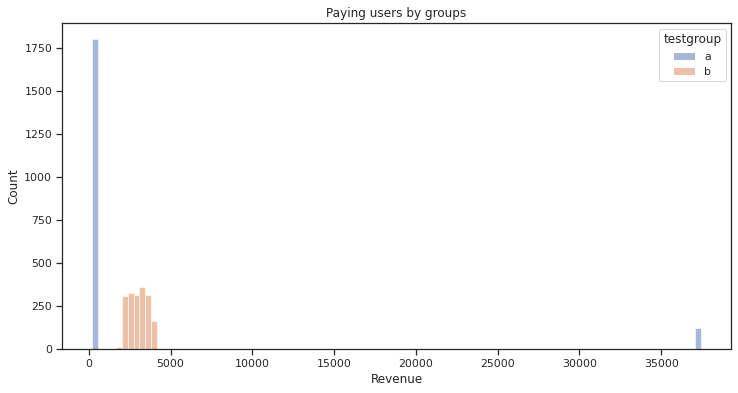

In [25]:
#Посмотрим на распределение платящих пользователей в тестовой и контрольной группах
plt.figure(figsize=(12, 6))
sns.histplot(x = 'revenue', data = df.query('revenue > 0'), hue = 'testgroup')
plt.title('Paying users by groups')
plt.xlabel('Revenue')
plt.ylabel('Count')
plt.show()

*На этом графике можно заметить интересную вещь: все высокодоходные пользователи находятся в контрольной группе, отсюда возникает вопрос, правильно ли сформированы группы, так как высокодоходные игроки должны быть в обеих группах. Значит сплитование проведено некорректно, в данном случае нужно было бы изменить сплитование, провести A/A тест, для того чтобы убедиться в его корректности, а затем уже проводить A/B тестирование*

*Но так как по условиям задачи A/B тестирование было проведено, будем проводить его на имющихся данных*

*Для начала проведем A/B тест и сравним есть ли стат. значимые различия между ARPU 2 групп*

In [26]:
#Проверим нормальность распределения
pg.normality(data = df, dv = "revenue", group = "testgroup", method = "normaltest")

,W,pval,normal
b,326622.395409,0.0,False
a,585152.731273,0.0,False


*Normaltest говорит нам о ненормальности распределений в обеих группах, так как p-value < 0.05, но на оснавании этого, мы не можем сказать, что t-test проводить нельзя, так как выборки большие и в данном случае работает центральная предельная теорема*

In [27]:
#Проверим гомогенность дисперсий при помощи критерия Левена 
pg.homoscedasticity(data = df, dv = "revenue", group = "testgroup")

,W,pval,equal_var
levene,0.389629,0.532495,True


*Так как дисперсии гомогенны, можем применять t-test*

In [28]:
pg.anova(data = df, dv = "revenue", between = "testgroup")

,Source,ddof1,ddof2,F,p-unc,np2
0,testgroup,1,404768,0.389629,0.532495,9.625973e-07


*Так как p-value > 0.05, отклонить H0 мы не можем, а это значит, что стат. значимых различий между ARPU контрольной и тестовой групп нет*

*Теперь проведем A/B тест и сравним есть ли стат. значимые различия между ARPPU 2 групп*

In [29]:
#Проверим нормальность распределения
pg.normality(data = df.query("revenue > 0"), dv = "revenue", group = "testgroup", method = "normaltest")

,W,pval,normal
a,1394.945784,1.234161e-303,False
b,1068.860008,7.943249e-233,False


*В данном случае снова распределения в группах не являются нормальными, но t-test все еще можно применять*

In [30]:
#Проверим гомогенность дисперсий при помощи критерия Левена 
pg.homoscedasticity(data = df.query("revenue > 0"), dv = "revenue", group = "testgroup")

,W,pval,equal_var
levene,80.855674,3.779690e-19,False


*Так как дисперсии в 2 группах разные, будем использовать t-test Уэлча*

In [31]:
ttest_ind(df.query('testgroup == "a" and revenue > 0').revenue, 
          df.query('testgroup == "b" and revenue > 0').revenue, 
          equal_var = False)

Ttest_indResult(statistic=-1.6446302664300838, pvalue=0.10020780398916015)

*Так как p-value > 0.05, мы не можем отклонить H0, это значит, что стат. значимых различий между ARPPU контрольной и тестовой групп нет*

*Также для проведения A/B тестов можно было использовать метод bootstrap, но он более ресурсоемкий, поэтому в данных случаях t-test предпочтительнее*

*Теперь прверим различия CR при помощи хи-квадрат*

In [32]:
#В исходной таблице создадим признак была ли конверсия в покупку
conversion = []
for i in df['revenue']:
    if i > 0:
        x = '1'
    else:
        x = '0'
    conversion.append(x)
df['conversion'] = conversion
df.head()

,user_id,revenue,testgroup,conversion
0,1,0,b,0
1,2,0,a,0
2,3,0,a,0
3,4,0,b,0
4,5,0,b,0


In [33]:
stats.chi2_contingency(pd.crosstab(df.testgroup, df.conversion))

(4.374729521260405,
 0.03647561892312613,
 1,
 array([[200239.10075104,   1863.89924896],
        [200797.89924896,   1869.10075104]]))

*Так как p-value < 0.05, H0 отклоняется, различия между группами статистически значимы*

**Общий вывод:**
*несмотря на то, что были проведены исследования таких метрик как ARPU, ARPPU, CR в контрольной и тестовой группах, сказать, какой набор предложений является лучшим нельзя, так как проведенные исследования отвечают лишь на вопрос, есть ли стат. значимые различия в группах, потому что, как мы помним, изначально сплитование было проведено некорректно, а значит и делать какие-то выводы о предложениях мы не можем. Поэтому оставляем текущий набор предложений до того момента, как будет проведено корректное A/B тестирование*



**Задание 3**

В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

**1-ый вариант событий:**

*DAU - количетсво уникальных пользователей за день, можно сравнивать данные во время тематических событий с обычными днями*

*Winners_rate - доля пользователей получивших бонусы, рассчитывается как количество пользователей, получивших бонусы за период (например месяц) / MAU. Можно сравнивать с другими тематическими событиями, чтобы анализировать сложность заданий для получения бонусов*

*AST - average session time, можно отслеживать, как изменилось среднее время сессиссии во время событий и в обычные дни*

*ASC - average session count, можно отслеживать, как изменилось среднее количество сессиссий во время событий и в обычные дни*

*Users_number_per_event_level - для того, чтобы отслеживать, какие уровни сложные либо неинтересные*

*Retention - можно мониторить удержание пользователей в игре, больше ли пользователей стало заходить в игру во время ивента по сравнению с обычными днями*

*ARPU, ARPPU - чтобы отслеживать, как изменился доход на юзера/платящего юзера во время тематического события по сравнению с обычными днями*

**2-ой вариант событий:**

*К выше перечисленным метрикам можно добавить следующие:*

*Rollback_rate_per_event_level - рассчитывается как количество откатов на каждом уровне/количество попыток пройти уровень, так мы поймем, какой уровень самый сложный для игроков*

*ARC - average rollback count before churn, среднее количество откатов у тех, кто попал в отток*

*Churn_level - уровень, с которого больше всего пользователей уходит в отток*

*Churn_rate - доля пользователей, ушедших в отток, можно сравнивать событийные и обычные дни*
